# Calculate various skill scores WRF



In [52]:
import xarray as xr
from datatree import DataTree
import matplotlib.pyplot as plt
import os
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.processing.select import select_point, get_shapefile_mask
from valenspy.diagnostic.functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean, calc_metrics_dt, calc_metrics_da,_add_ranks_metrics, root_mean_square_error
from valenspy.diagnostic.visualizations import plot_time_series, plot_map, plot_metric_ranking
from pathlib import Path
import pandas as pd
import numpy as np
import xoak
from sklearn.neighbors import BallTree as skBallTree
from scipy.stats import pearsonr

from functions import point_data_2_climate_grid

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


### 0. Defining observational data

In [53]:
obs_data_str = 'netatmo'
lu_group = "urban"

In [54]:
metrics = ["rmse", "mean_bias", "pearson_correlation2", "mean_absolute_error", "spearman_correlation"]
start_date = "2019-07-25 00:00:00"
end_date = "2019-07-25 23:59:59" 
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

### 1. Getting model data

In [55]:
file_wrf = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/geo_em.d03_new.nc"
ds = xr.open_mfdataset(file_wrf, combine='by_coords')
ds = ds.assign_coords({"lat":ds.CLAT})
ds = ds.assign_coords({"lon":ds.CLONG})


### 2. Loading Observation Data + Converting to right format

In [56]:
ucl_dir = "/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/"
if obs_data_str == "aws":
    # Loading data
    aws_file = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/fiens/UCL/aws_1hour_20190701-20190801.csv'
    obs_data = pd.read_csv(aws_file)
    obs_data["timestamp"] = obs_data["timestamp"].str.replace("T", " ")
    obs_data["time"] = pd.to_datetime(obs_data.timestamp)
    obs_data[['lat', 'lon']] = obs_data['the_geom'].str.extract(r'POINT \(([\d.-]+) ([\d.-]+)\)')
    
    # Convert the new columns to float
    obs_data['lat'] = obs_data['lat'].astype(float)
    obs_data['lon'] = obs_data['lon'].astype(float)
    obs_data['time'] = pd.to_datetime(obs_data["timestamp"])
    obs_data = obs_data.rename(columns = {"temp_dry_shelter_avg": "T2"})
    obs_data["T2"] = obs_data["T2"]+273.15
    obs_data['date'] = pd.to_datetime(obs_data['timestamp']).dt.date

elif obs_data_str == "wow":
    # Loading data
    wow_file = ucl_dir + "wow_qc_BE.csv"
    orig_data = pd.read_csv(wow_file)
    orig_data = orig_data.loc[np.where(orig_data.m4)]
    obs_data = orig_data[["p_id", "lon", "lat", "time", "ta"]]
    obs_data = obs_data.rename(columns = {"ta" : "T2"})
    obs_data["code"] = obs_data["lat"].astype(str) + '-' + obs_data["lon"].astype(str)

    # Averaging stations that fall within same gridcell
    [obs_data_agg, obs_indices] = point_data_2_climate_grid(obs_data, ds, 'T2')

    # Converting format
    obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date
    obs_data = obs_data_agg.rename(columns = {"grid_index": "code"})
    obs_data['time'] = pd.to_datetime(obs_data["time"])
    obs_data["T2"] = obs_data["T2"]+273.15
    obs_data['date'] = pd.to_datetime(obs_data['time']).dt.date
    obs_data["lat"] = np.round(obs_data.lat, 6)
    obs_data["lon"] = np.round(obs_data.lon, 6)
    obs_data["hour"] = pd.to_datetime(obs_data['time']).dt.hour

elif obs_data_str == "netatmo":
    # Loading data
    netatmo_file = ucl_dir + "netatmo_qc.csv"
    orig_data = pd.read_csv(netatmo_file)
    orig_data = orig_data.loc[np.where(orig_data.m4)]
    obs_data = orig_data.rename(columns = {"ta": "T2"})
    obs_data["T2"] = obs_data["T2"] + 273.15

    # Averaging stations that fall within same gridcell
    [obs_data_agg, obs_indices] = point_data_2_climate_grid(obs_data, ds, 'T2')

    # Converting format
    obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date
    obs_data = obs_data_agg.rename(columns = {"grid_index": "code"})
    obs_data['time'] = pd.to_datetime(obs_data["time"])
    obs_data["lat"] = np.round(obs_data.lat, 6)
    obs_data["lon"] = np.round(obs_data.lon, 6)

obs_data = obs_data.loc[np.where(np.logical_and(obs_data.time >= start_date, obs_data.time <= end_date))].reset_index(drop = True)

# Checking whether the stations have data for each hour
full_range = pd.date_range(start=start_date, 
                           end=end_date, 
                           freq="h")  # Hourly intervals
drop_stations = []
for c in np.unique(obs_data.code):
    code_temp = obs_data.loc[np.where(obs_data.code == c)].reset_index(drop = True)
    missing_hours = full_range.difference(code_temp["time"])
    if len(missing_hours) > 0:
        drop_stations.append(c)
#print("In " + obs_data_str + str(len(drop_stations)) " are removed.")

drop_indices = [i for i in np.arange(0, len(obs_data)) if obs_data.loc[i, "code"] in drop_stations]
obs_data = obs_data.drop(drop_indices).reset_index(drop = True)



/tmp/ipykernel_1662148/225840095.py:52: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  obs_data_agg.date = pd.to_datetime(obs_data_agg.time).dt.date


In [57]:
obs_data = obs_data.reset_index()
d_coord_points = obs_data[["code", "lat", "lon"]]

d_coord_points = d_coord_points.drop_duplicates().reset_index(drop = True)
#d_coord_points.to_csv(ucl_dir + "Locations_" + obs_data_str + "_sensor.csv", index = False)

if obs_data_str == "wow" :
    if lu_group:
        d_coord_points = pd.read_csv(ucl_dir + 'Location_qc_' + lu_group + '_' + obs_data_str + ".csv")
elif obs_data_str == "netatmo":
    if lu_group:
        d_coord_points = pd.read_csv(ucl_dir + 'Location_' + lu_group + '_' + obs_data_str + ".csv")
   

d_coord_points["lat"] = np.round(d_coord_points.lat, 6)
d_coord_points["lon"] = np.round(d_coord_points.lon, 6)


In [58]:
obs_data = obs_data.set_index(['lat', 'lon', 'time'])

## 2. Skill score calculation
Here, temperature is evaluated

Load point modelled data and observations

In [59]:
files = sorted(os.listdir(ucl_dir + 'WRF_output'))
print(files)


['WRF_run0_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run1_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run2_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run3_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run4_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run5_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run6_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc', 'WRF_run7_T2,V10,U10,PSFC,RAINNC,TH2,Q2,ALBEDO_20190725-20190726.nc']


In [60]:
d_da_mod = {}
column_names = metrics
column_names.append('member')
column_names.append('variable')

df_run_metrics = pd.DataFrame(np.zeros([np.shape(files)[0], np.shape(metrics)[0]]), columns = column_names)
variable = "T2"

for f in np.arange(0, len(files)):
    file = files[f]
    experiment = file.split('_')[1]
    print(experiment)
    df_run_metrics.loc[f, "member"] = experiment

    df_run_metrics.loc[f, "variable"] = variable 
    ds_mod = xr.open_mfdataset(ucl_dir + 'WRF_output/' + file, combine='by_coords').rename({"XTIME": "time"})
    df_metrics = pd.DataFrame(np.zeros([np.shape(d_coord_points)[0]+1, np.shape(metrics)[0]]), columns = metrics)
    for i in np.arange(0, len(d_coord_points)):
        point_coord = d_coord_points.loc[i]
        lat_array = xr.DataArray(np.array([point_coord.lat]), dims='point')
        lon_array = xr.DataArray(np.array([point_coord.lon]), dims='point')

        ds_mod = ds_mod.where((ds_mod.time >= start_date) & (ds_mod.time <= end_date), drop=True)
        ds_mod.xoak.set_index(['XLAT', 'XLONG'], 'sklearn_geo_balltree')
        ds_mod_point = ds_mod.xoak.sel(XLAT = lat_array, XLONG = lon_array)

        da_mod_point = ds_mod_point[variable].compute()
        df_obs_point = obs_data.loc[point_coord.lat, point_coord.lon, :]

        for metric in metrics:
            if metric == "rmse":
                df_metrics.loc[i, metric] = root_mean_square_error(da_mod_point.squeeze(), df_obs_point[variable])
            if metric == 'mean_bias':
                df_metrics.loc[i, metric] = mean_bias(da_mod_point.squeeze(), df_obs_point[variable])
            elif metric == "mean_absolute_error":
                df_metrics.loc[i, metric] = mean_absolute_error(da_mod_point.squeeze(), df_obs_point[variable])
            elif metric == "spearman_correlation":
                df_metrics.loc[i, metric] = spearman_correlation(da_mod_point.squeeze(), df_obs_point[variable])
            elif metric == "pearson_correlation2":
                df_metrics.loc[i, metric] = (pearsonr(da_mod_point.squeeze(), df_obs_point[variable])[0])**2


            
            
    for metric in metrics:        
        df_metrics.loc[len(d_coord_points), metric] = np.mean(df_metrics.loc[0:len(d_coord_points)-1, metric])
    
    df_run_metrics.loc[f] = df_metrics.loc[len(d_coord_points)]
    df_run_metrics.loc[f, "member"] = experiment
    if lu_group:
        df_run_metrics.loc[f, "variable"] = variable + '(' + lu_group + ')'
    else:
        df_run_metrics.loc[f, "variable"] = variable 

    

run0


/tmp/ipykernel_1662148/821712551.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'run0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_run_metrics.loc[f, "member"] = experiment
/tmp/ipykernel_1662148/821712551.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'T2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_run_metrics.loc[f, "variable"] = variable


run1
run2
run3
run4
run5
run6
run7


In [61]:
df_run_metrics

,rmse,mean_bias,pearson_correlation2,mean_absolute_error,spearman_correlation,member,variable
0,2.543479,0.387327,0.887237,2.073374,0.920155,run0,T2(urban)
1,2.703728,-0.486312,0.897538,2.257096,0.945129,run1,T2(urban)
2,2.496301,-0.410573,0.912118,2.083435,0.965635,run2,T2(urban)
3,3.293015,-0.114432,0.843566,2.797959,0.912031,run3,T2(urban)
4,2.527728,-1.015147,0.919037,2.113994,0.965426,run4,T2(urban)
5,2.894698,-0.334017,0.876832,2.448160,0.933339,run5,T2(urban)
6,2.689656,-0.479737,0.898832,2.251184,0.946568,run6,T2(urban)
7,2.798670,-0.188659,0.891509,2.359596,0.942661,run7,T2(urban)


In [62]:
df_metrics_long = pd.melt(df_run_metrics, id_vars=["member", "variable"], var_name="metric", value_name="value")

In [63]:
# df_ranks = _add_ranks_metrics(df_metrics_long)
# df_ranks

Plot the ranks in a heatmap

In [64]:
def scaling_metrics(df_metric, metric, method = "minmax", opt_is_zero = False):
    if opt_is_zero:
        values_metric = abs(df_metric[metric])
        min_value = max(values_metric)
        max_value = min(values_metric)
    else:
        values_metric = df_metric[metric]
        min_value = min(values_metric)
        max_value = max(values_metric)
    scaled_values = (values_metric- min_value)/(max_value - min_value)

    return scaled_values


In [65]:
from valenspy.diagnostic.visualizations import create_custom_cmap
import seaborn as sns
import matplotlib.colors as mcolors

def plot_metric(df_metric, ax=None, var_member = "member", plot_colorbar=True, metrics = ["rmse", "mean_bias", "pearson_correlation2", "mean_absolute_error", "spearman_correlation"], hex_color1 = None, hex_color2=None, **kwargs):
    """
    Plots a heatmap of the ranking of metrics for different model members.

    This function takes a DataFrame of metrics, calculates the rankings of these metrics 
    for each model member, and creates a heatmap representing the ranks. The plot can 
    optionally include a colorbar to represent the ranking levels. If no axis is provided, 
    a new figure and axis are created for the plot.
    Parameters:
    -----------
    df_metric : pd.DataFrame
        A DataFrame containing the calculated metrics for different model members. Each column 
        represents a model member, and each row represents a metric.
    ax : matplotlib.axes.Axes, optional
        A pre-existing axis to plot the heatmap. If None (default), a new figure and axis 
        are created.
    plot_colorbar : bool, optional
        If True (default), a colorbar is added to the plot to represent the rank levels. 
        If False, the heatmap is plotted without a colorbar.
    hex_color1 : str
        The starting color of the colormap in hex format (e.g., '#FF0000' for red).
    hex_color2 : str
        The ending color of the colormap in hex format (e.g., '#0000FF' for blue).

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axis object containing the heatmap plot.

    Notes:
    ------
    - The color map has the 'summer' palette as default and is resampled to the number of model members.
    - A customized color map can be included or determined as an interpolation between two colorcodes (hex codes)
    - Rankings are normalized based on the number of model members.
    - The function supports colorbar ticks to represent custom rank labels, which are added 
      only if `plot_colorbar=True`.
    
    Example:
    --------
    plot_metric_ranking(df_metric, ax=None, plot_colorbar=True)
    -> Generates a heatmap of metric rankings for each model member, with an optional colorbar.
    """
    df_rescaled = df_metric.copy()

    for metric in metrics:
        if metric in ["rmse", "mean_bias", "mean_absolute_error"]:
            df_rescaled[metric] = scaling_metrics(df_metric, metric, opt_is_zero = True)
        if metric in ["pearson_correlation2", "spearman_correlation"]:
            df_rescaled[metric] = scaling_metrics(df_metric, metric, opt_is_zero = False)

    #num_levels = df_metric["member"].nunique()

    if "cmap" not in kwargs:
        if hex_color1 and hex_color2:
            cmap = create_custom_cmap(hex_color1=hex_color1, hex_color2=hex_color2, num_colors=num_levels)
        else:
            cmap = plt.get_cmap('RdYlGn')
    else:
        cmap = plt.get_cmap(kwargs.pop("cmap"))
    
    #boundaries = np.arange(1, num_levels + 2, 1)
    #norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    if ax is None: 
        fig, ax = plt.subplots()

    if "title" in kwargs:
        ax.set_title(kwargs.pop("title"), loc="right")
    else:
        plt.title(df_metric.loc[0, "variable"])

    heatmap = sns.heatmap(df_rescaled[metrics], ax=ax, cbar=plot_colorbar, cmap = cmap,  **kwargs,annot = df_metric[metrics], fmt=".4f", yticklabels=df_metric[var_member])
    ax.set_ylabel("Members")
    
    if plot_colorbar:
        colorbar = heatmap.collections[0].colorbar
        colorbar.set_ticks([0,1])  # Set the ticks you want
        colorbar.set_ticklabels(["worst", "best"])  # Set the custom labels for the ticks
    
    return ax

In [66]:
df_run_metrics = df_run_metrics.loc[:,~df_run_metrics.columns.duplicated()].copy()

<Axes: title={'right': 'T2 (netatmo / urban)'}, ylabel='Members'>

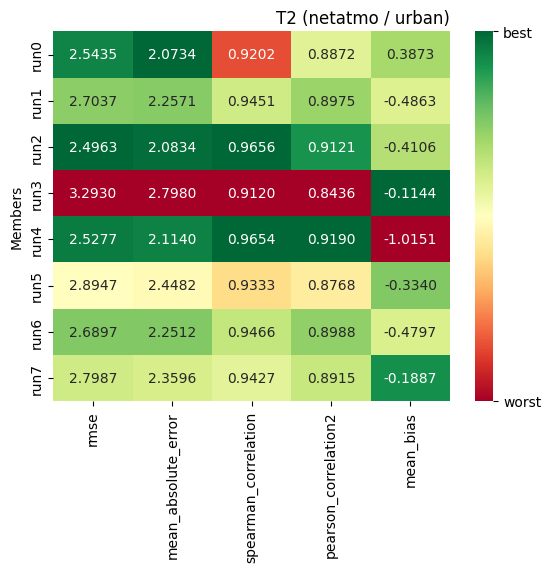

In [67]:
if lu_group:
    title_plot = 'T2 (' + obs_data_str  + ' / ' + lu_group + ')'
else:
    title_plot = 'T2 (' + obs_data_str  + ')'


plot_metric(df_run_metrics, metrics = ["rmse", "mean_absolute_error", "spearman_correlation", "pearson_correlation2", "mean_bias"], title = title_plot)

In [68]:
# calculate and plot the ranking of this metric

ax = plot_metric_ranking(df_ranks, title=variable)


NameError: name 'df_ranks' is not defined